# Day-ahead Bitcoin Price Forecasting using the Prophet model

This notebook builds a **full Prophet-based pipeline** for:

> **Day-ahead Bitcoin Price Forecasting (BTC-USD)**

We will:

- Clean and prepare a BTC-USD dataset (with some quirks in the raw CSV).
- Explore non-stationarity and volatility (returns & rolling volatility).
- Build a Prophet-ready dataset using **log of a Typical Price**.
- Train a **baseline additive Prophet model** and inspect trend/seasonality.
- Analyze residuals and link them to volatility (heteroskedasticity).
- Implement a **day-ahead forecasting protocol**:
  - Using **Prophet’s built-in `cross_validation`**.
  - Using a **manual rolling loop** for pedagogical purposes.
- Build an **improved multiplicative model** with tuned changepoints.
- Compare baseline vs improved in terms of:
  - MAE, RMSE, MAPE
  - **Directional accuracy** (up/down prediction of next-day move).
- Conclude by linking the results to Prophet theory:
  - \( y(t) = g(t) + s(t) + h(t) + \varepsilon_t \)


---

## 1. Import and Load the Bitcoin dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error

### Plotting style

In [2]:
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 5)

### Display options

In [3]:
pd.set_option("display.max_columns", None)

### -----------------------------
## 1.1 Load raw BTC-USD.csv safely
### -----------------------------

In [4]:
df_raw = pd.read_csv("BTC-USD.csv")

print("Original columns:", df_raw.columns.tolist())
display(df_raw.head(10))

Original columns: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']


,Price,Close,High,Low,Open,Volume
0,Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,7200.17431640625,7254.33056640625,7174.9443359375,7194.89208984375,18565664997
3,2020-01-02,6985.47021484375,7212.1552734375,6935.27001953125,7202.55126953125,20802083465
4,2020-01-03,7344.88427734375,7413.71533203125,6914.99609375,6984.4287109375,28111481032
5,2020-01-04,7410.65673828125,7427.3857421875,7309.51416015625,7345.37548828125,18444271275
6,2020-01-05,7411.3173828125,7544.4970703125,7400.53564453125,7410.45166015625,19725074095
7,2020-01-06,7769.21923828125,7781.8671875,7409.29296875,7410.4521484375,23276261598
8,2020-01-07,8163.6923828125,8178.2158203125,7768.2275390625,7768.68212890625,28767291327
9,2020-01-08,8079.86279296875,8396.73828125,7956.7744140625,8161.935546875,31672559265


We inspect the raw CSV first because:

- The **first column may be called `"Price"`** but actually stores **dates**.
- There can be extra header-like rows such as `"Ticker"` and `"Date"` inside the data.
- We need to:
  - Rename the first column to `"Date"`.
  - Parse it as `datetime` with `errors='coerce'`.
  - Drop rows where the date is invalid (these will correspond to `"Ticker"`, `"Date"`, etc.).
  - Convert price/volume columns to numeric.


## 1.2 Clean and prepare the BTC-USD dataset

In [5]:
df = df_raw.copy()

# Rename the first column to "Date" (it may be named "Price" in the raw file)
first_col = df.columns[0]
df = df.rename(columns={first_col: "Date"})

# Parse Date to datetime; invalid strings become NaT
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

# Drop rows where Date could not be parsed (e.g. "Ticker", "Date", etc.)
df = df.dropna(subset=["Date"])

# Identify numeric columns we care about and convert them
numeric_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Sort by Date and set as index
df = df.sort_values("Date").set_index("Date")

# Optionally drop rows where Close is missing (we need it for analysis)
if "Close" in df.columns:
    df = df.dropna(subset=["Close"])

print("Cleaned dataset shape:", df.shape)
display(df.head())

print("\nDataFrame info after cleaning:")
display(df.info())

print("\nSummary statistics:")
display(df.describe())

Cleaned dataset shape: (2143, 5)


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095



DataFrame info after cleaning:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2143 entries, 2020-01-01 to 2025-11-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2143 non-null   float64
 1   High    2143 non-null   float64
 2   Low     2143 non-null   float64
 3   Open    2143 non-null   float64
 4   Volume  2143 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 100.5 KB


None


Summary statistics:


,Close,High,Low,Open,Volume
count,2143.000000,2143.000000,2143.000000,2143.000000,2.143000e+03
mean,46225.530281,47096.201219,45225.758697,46183.413244,3.600267e+10
std,31105.312029,31569.945721,30585.981010,31094.049111,2.127819e+10
min,4970.788086,5331.833984,4106.980957,5002.578125,5.331173e+09
25%,21596.555664,21884.274414,20997.401367,21561.271484,2.180296e+10
50%,39097.859375,39902.949219,37728.144531,38886.828125,3.163423e+10
75%,63186.886719,64373.062500,61734.574219,63168.056641,4.459778e+10
max,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11


---

# 2. Exploratory Data Analysis (non-stationarity & volatility)

We now explore:

- The raw **Close** price.
- Basic statistics and a **log-transformation**.
- A more robust **Typical Price**:
  \[
    \text{Typical Price} = \frac{\text{High} + \text{Low} + \text{Close}}{3}
  \]
- **Daily returns** and **rolling volatility**.


## 2.1 Plot the raw closing price

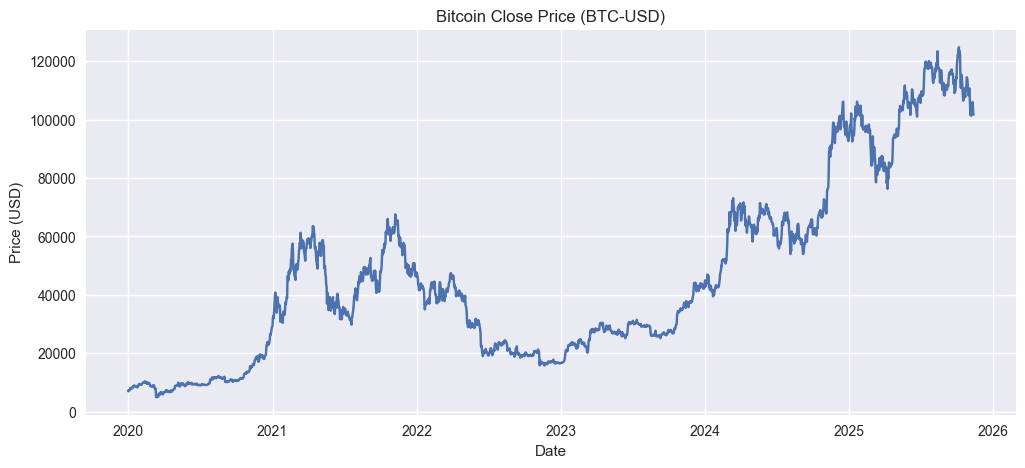

In [6]:
if "Close" not in df.columns:
    raise ValueError("Column 'Close' not found in the dataset. Please check the CSV structure.")

close = df["Close"]

plt.figure()
plt.plot(close.index, close.values)
plt.title("Bitcoin Close Price (BTC-USD)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

The Bitcoin close price is **strongly non-stationary**:

- Large **uptrends** (bull runs) and **sharp crashes**.
- Sudden regime changes (e.g. around major macro or crypto events).
- This behaviour is challenging for models that assume constant mean and variance.

## 2.2 Basic statistics and transformations

Close price statistics:
min       4970.788086
max     124752.531250
mean     46225.530281
std      31105.312029
Name: Close, dtype: float64

Using Typical Price as the main price series for modeling.



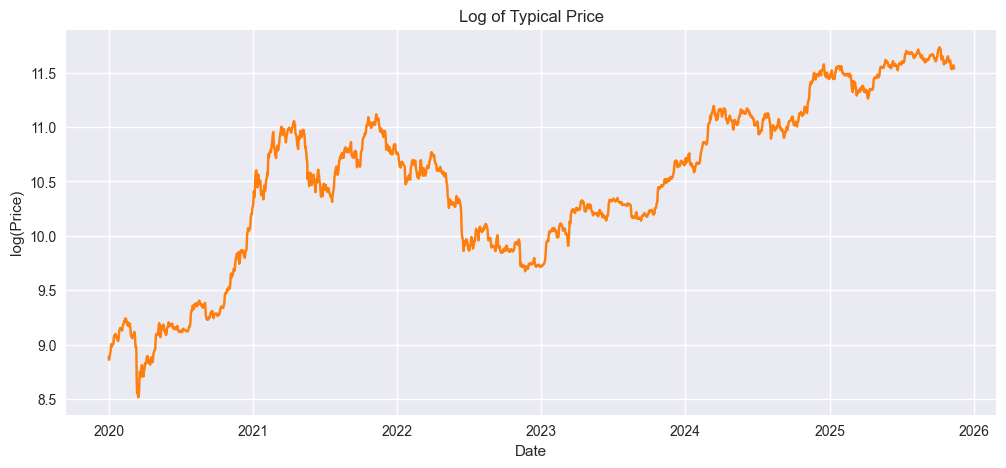

In [7]:
# Basic stats on Close
stats_close = close.agg(["min", "max", "mean", "std"])
print("Close price statistics:")
print(stats_close)

# Create Typical_Price if High and Low exist
if {"High", "Low", "Close"}.issubset(df.columns):
    df["Typical_Price"] = (df["High"] + df["Low"] + df["Close"]) / 3.0
    price_series = df["Typical_Price"]
    price_label = "Typical Price"
else:
    # Fallback: use Close as the only available reasonable price
    df["Typical_Price"] = df["Close"]
    price_series = df["Typical_Price"]
    price_label = "Close (fallback as Typical Price)"

print(f"\nUsing {price_label} as the main price series for modeling.\n")

# Log of the chosen price (Typical_Price by design in this notebook)
df["log_price"] = np.log(price_series)

plt.figure()
plt.plot(df.index, df["log_price"], color="tab:orange")
plt.title(f"Log of {price_label}")
plt.xlabel("Date")
plt.ylabel("log(Price)")
plt.grid(True)
plt.show()

**Why Typical Price and log-prices?**

- The **Typical Price** averages High, Low, and Close:
  - Smoother than using Close alone.
  - Reduces the impact of extreme intraday spikes.
  - Better represents the “average” daily price level.

- Taking the **logarithm** of the price:
  - Stabilizes variance when the series grows exponentially.
  - Transforms **multiplicative** changes into **additive** ones.
  - Fits naturally with Prophet’s additive decomposition:
    \[
      y(t) = g(t) + s(t) + h(t) + \varepsilon_t
    \]
  where here \( y(t) = \log(\text{Typical Price}_t) \).


## 2.3 Volatility analysis: daily returns and rolling volatility

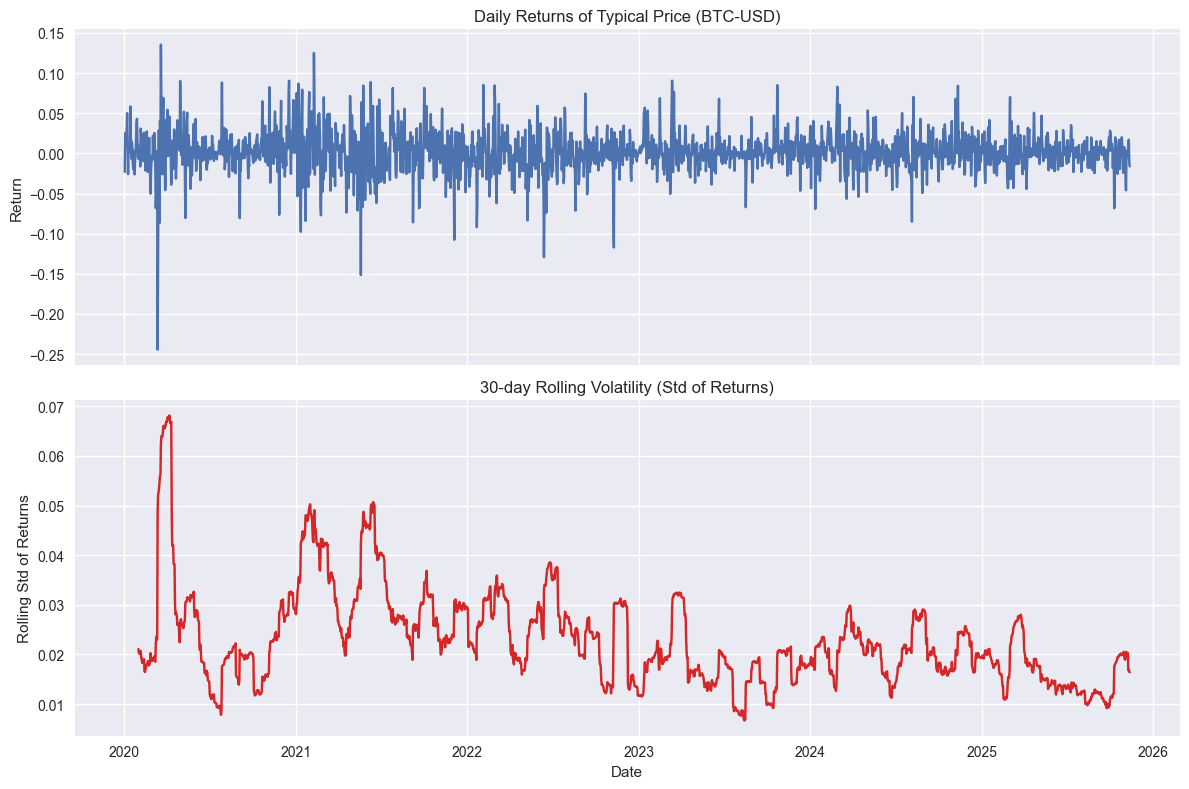

In [8]:
# Daily returns on the chosen price (Typical_Price)
df["return"] = df["Typical_Price"].pct_change()

# 30-day rolling volatility (standard deviation of returns)
rolling_window = 30
df["rolling_volatility"] = df["return"].rolling(window=rolling_window).std()

returns = df["return"].dropna()
rolling_vol = df["rolling_volatility"].dropna()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(returns.index, returns.values)
axes[0].set_title(f"Daily Returns of {price_label} (BTC-USD)")
axes[0].set_ylabel("Return")
axes[0].grid(True)

axes[1].plot(rolling_vol.index, rolling_vol.values, color="tab:red")
axes[1].set_title(f"{rolling_window}-day Rolling Volatility (Std of Returns)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Rolling Std of Returns")
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Interpretation:**
- **Returns** (rather than prices) look **more stationary**, fluctuating around zero.
- Volatility is **time-varying**:
  - Calm periods with low volatility.
  - Turbulent periods with large, clustered spikes (volatility clustering).
- This is called **heteroskedasticity**.

Prophet will mainly model the **conditional mean** (trend + seasonality) of \( y(t) \).
It does **not** explicitly model volatility, so a lot of this time-varying variance remains in the error term \( \varepsilon_t \).

---

# 3. Data preparation for Prophet

Prophet expects a DataFrame with:

- `ds`: datestamps (datetime),
- `y` : target variable (here **log of Typical Price**).

We also create an **initial train/test split** (last 365 days as test) for a traditional hold-out evaluation.  
The **main objective** of this notebook, however, will be **day-ahead forecasting** with a rolling protocol.


## 3.1 Create Prophet dataframe (ds, y)

In [9]:
df_reset = df.reset_index()  # Date becomes a column again

df_prophet = df_reset[["Date", "log_price"]].rename(
    columns={"Date": "ds", "log_price": "y"}
)

display(df_prophet.head())

,ds,y
0,2020-01-01,8.883199
1,2020-01-02,8.859974
2,2020-01-03,8.885238
3,2020-01-04,8.906870
4,2020-01-05,8.916253


We now have:

- `ds` = calendar date.
- `y`  = log(Typical_Price).

This representation is well-suited to Prophet’s additive decomposition.


## 3.2 Train/Test split for initial hold-out check

In [10]:
test_size = 365  # last year as test set (approx.)

if len(df_prophet) <= test_size + 365:
    print("Warning: dataset is relatively short for a 365-day test set.")
    
train = df_prophet.iloc[:-test_size].copy()
test = df_prophet.iloc[-test_size:].copy()

cutoff_date = train["ds"].max()

print(f"Total observations: {len(df_prophet)}")
print(f"Train size: {len(train)}, Test size: {len(test)}")
print(f"Train/Test cutoff date: {cutoff_date.date()}")

Total observations: 2143
Train size: 1778, Test size: 365
Train/Test cutoff date: 2024-11-12


We keep this **train/test split** only for:

- A **one-year ahead forecast visualization**.
- Basic intuition about Prophet’s behaviour on longer horizons.

However, this is **not** our main evaluation method.  
For day-ahead forecasting, we will later use a **rolling-origin evaluation** (cross-validation and a manual loop).


---

# 4. Baseline Prophet model (additive, initial evaluation)

We first build a **baseline additive model**:

- `yearly_seasonality=True`
- `weekly_seasonality=True`
- `seasonality_mode='additive'`

We train it on the **training set only**, then forecast over the test window to visualize a 1-year horizon scenario.


## 4.1 Baseline model definition and training on the training set

In [11]:
m_baseline = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode="additive",  # baseline: additive seasonality
)

m_baseline.fit(train)

14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing


## 4.2 Forecast over the hold-out test window (for intuition)

In [12]:
# Build future dataframe up to the end of the test set
future_baseline = m_baseline.make_future_dataframe(
    periods=len(test),  # extend by test_size days
    freq="D"
)

# FULL forecast: all Prophet columns (ds, trend, yhat, weekly, yearly, ...)
forecast_full_baseline = m_baseline.predict(future_baseline)

# Light version for merging and metrics
forecast_baseline = forecast_full_baseline[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()

# Merge with original log-price data
df_merged_baseline = df_prophet.merge(forecast_baseline, on="ds", how="left")

# Convert back to price level for interpretability
df_merged_baseline["y_actual_price"] = np.exp(df_merged_baseline["y"])
df_merged_baseline["yhat_price"] = np.exp(df_merged_baseline["yhat"])
df_merged_baseline["yhat_lower_price"] = np.exp(df_merged_baseline["yhat_lower"])
df_merged_baseline["yhat_upper_price"] = np.exp(df_merged_baseline["yhat_upper"])

display(df_merged_baseline.tail())


,ds,y,yhat,yhat_lower,yhat_upper,y_actual_price,yhat_price,yhat_lower_price,yhat_upper_price
2138,2025-11-08,11.536361,11.841942,8.844882,14.499019,102371.239583,138960.039983,6938.788363,1.980816e+06
2139,2025-11-09,11.550885,11.840487,8.823697,14.475636,103868.960938,138758.088461,6793.334606,1.935035e+06
2140,2025-11-10,11.567767,11.840370,8.701772,14.484749,105637.312500,138741.754190,6013.561234,1.952750e+06
2141,2025-11-11,11.554972,11.840168,8.828235,14.509903,104294.351562,138713.843270,6824.229682,2.002492e+06
2142,2025-11-12,11.538584,11.839632,8.713120,14.499380,102599.013021,138639.410746,6082.189075,1.981530e+06


## 4.3 Plot full forecast with changepoints

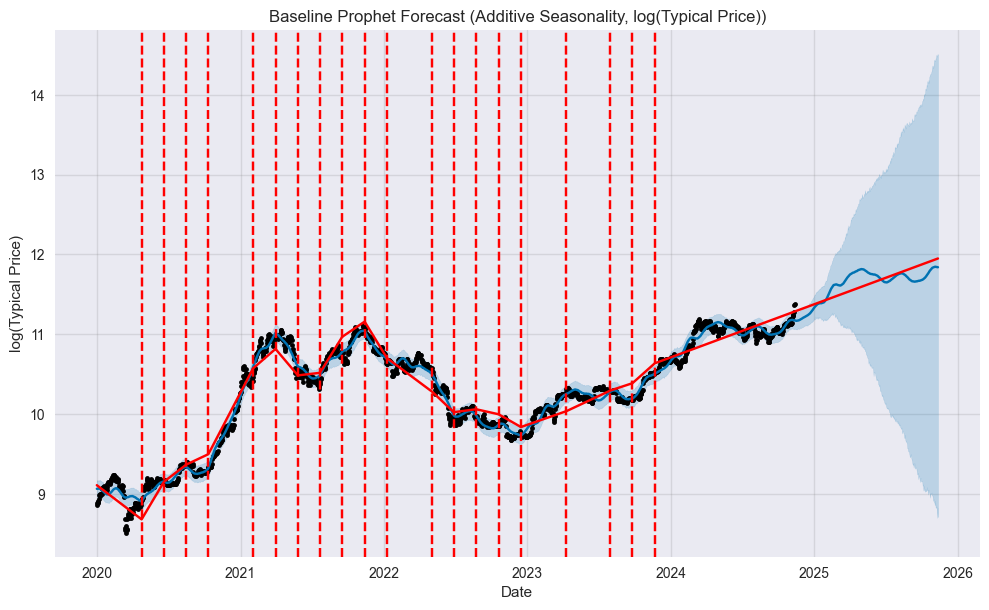

In [13]:
from prophet.plot import add_changepoints_to_plot

fig1 = m_baseline.plot(forecast_full_baseline)
plt.title("Baseline Prophet Forecast (Additive Seasonality, log(Typical Price))")
plt.xlabel("Date")
plt.ylabel("log(Typical Price)")
plt.grid(True)

_ = add_changepoints_to_plot(fig1.gca(), m_baseline, forecast_full_baseline)
plt.show()


**Prophet decomposition reminder:**

\[
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
\]

- \( g(t) \): **Trend** — here piecewise linear with automatically detected **changepoints**.
- \( s(t) \): **Seasonality** — weekly and yearly components (Fourier series).
- \( h(t) \): **Holiday/Event effects** — not explicitly used here, but could model e.g. Bitcoin halving dates.
- \( \varepsilon_t \): **Error term**, containing noise and unmodeled effects (including volatility).

Changepoints are crucial for Bitcoin because the market exhibits **strong regime shifts** (bubbles, crashes, macro events).


## 4.4 Components plot: trend + weekly + yearly

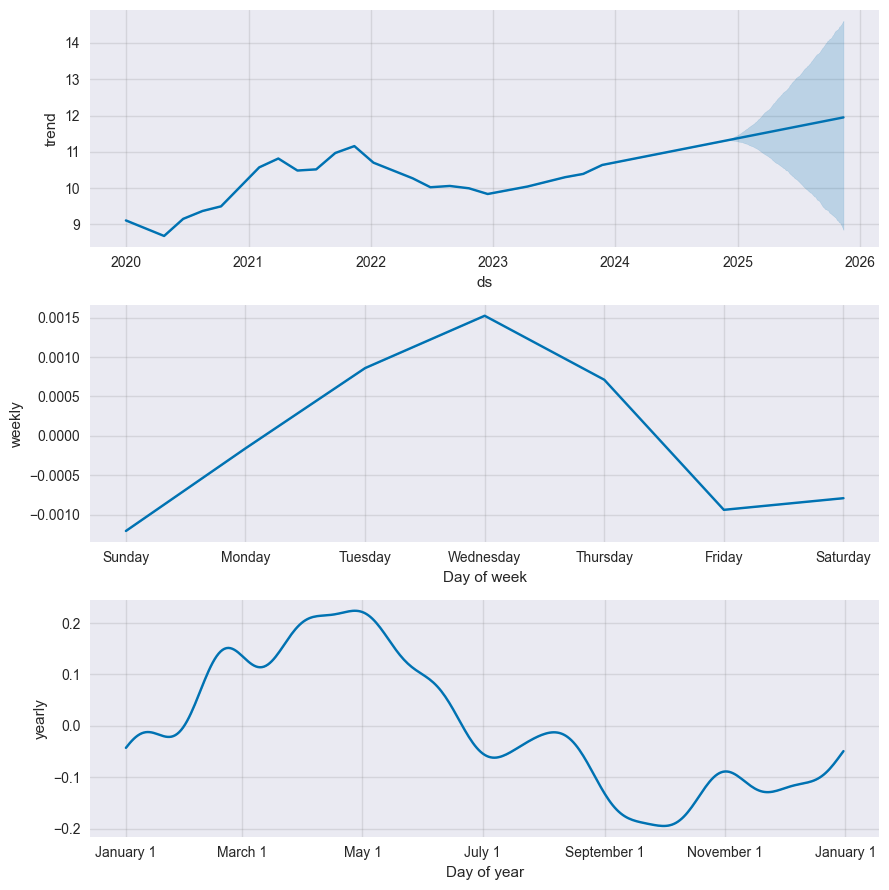

In [14]:
fig2 = m_baseline.plot_components(forecast_full_baseline)
plt.show()

**Interpretation (qualitative):**

- The **trend component** reflects long-term growth and major turning points.
- **Weekly seasonality** may show minor differences between days of the week (e.g., weekend vs weekday behaviour).
- **Yearly seasonality** may capture recurring calendar effects if present.

For BTC, these seasonal signals are usually weaker than in classical business datasets (like sales or website traffic), but Prophet still attempts to capture them.


---

# 5. Residual analysis (link with volatility)

We now look at **residuals on the training period**:

- In log-space: `residual = y_train - yhat_train`.
- Their **rolling standard deviation**.
- How they relate to volatility clustering.


### 5.1 Residuals on the training set

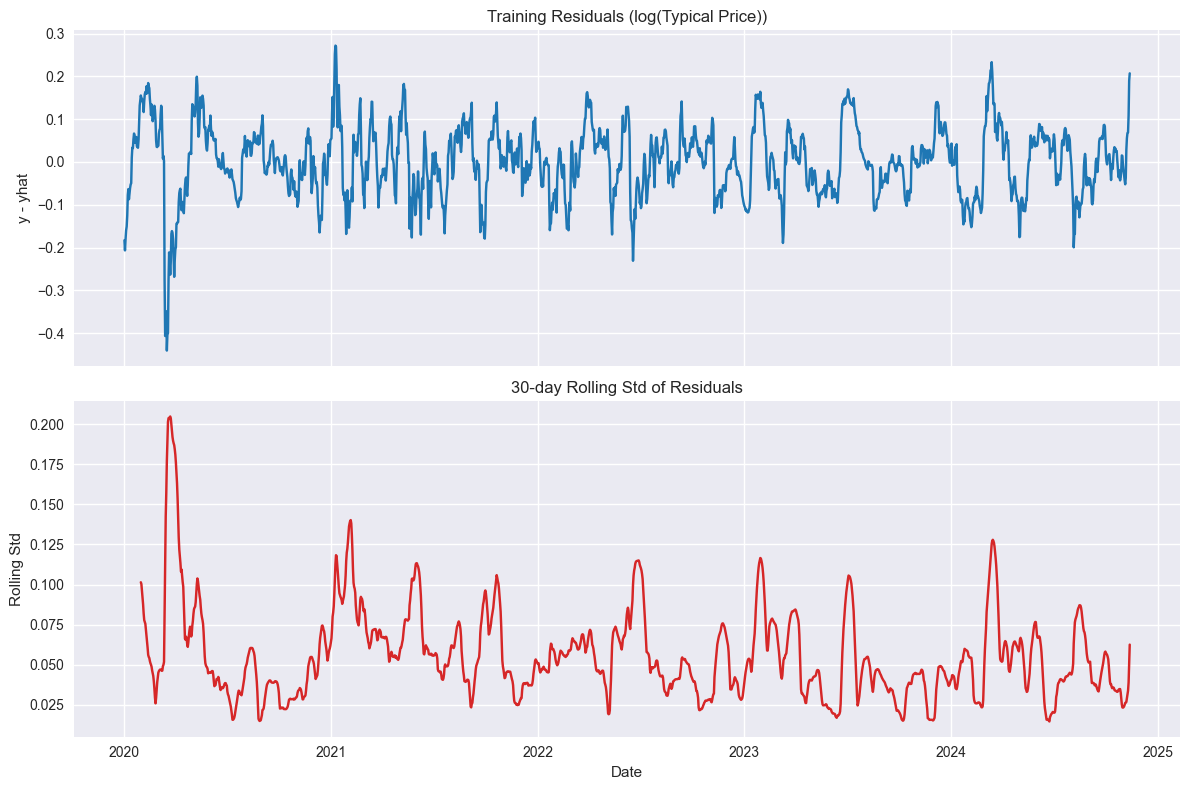

In [15]:
# Restrict merged predictions to the training window
df_train_pred = df_merged_baseline[df_merged_baseline["ds"] <= cutoff_date].copy()

# Residuals in log-price space
df_train_pred["residual_log"] = df_train_pred["y"] - df_train_pred["yhat"]

# Rolling standard deviation of residuals
resid_window = 30
df_train_pred["resid_rolling_std"] = df_train_pred["residual_log"].rolling(
    window=resid_window
).std()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(df_train_pred["ds"], df_train_pred["residual_log"], color="tab:blue")
axes[0].set_title("Training Residuals (log(Typical Price))")
axes[0].set_ylabel("y - yhat")
axes[0].grid(True)

axes[1].plot(df_train_pred["ds"], df_train_pred["resid_rolling_std"], color="tab:red")
axes[1].set_title(f"{resid_window}-day Rolling Std of Residuals")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Rolling Std")
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Discussion:**

- Residuals still show periods with **larger** and **smaller** variance.
- This is again **heteroskedasticity**: volatility is not constant over time.
- Prophet is modeling the **expected level** (trend + seasonality) of \( y(t) \).
- Volatility clustering remains in the error term \( \varepsilon_t \).

In a more advanced pipeline, one might combine Prophet with a **GARCH-type model** (on returns) to explicitly model volatility. Here, we focus on Prophet for the **price level**.


---

# 6. Day-ahead forecasting protocol (new main objective)

Until now, we looked at a **1-year horizon forecast** for intuition.  
However, real trading and risk-management applications often care about **day-ahead forecasts**:

> At each date \( t \), we use data up to \( t \) to forecast \( y(t+1) \).

This section introduces a **rolling day-ahead evaluation** using:

1. Prophet’s built-in **`cross_validation`** function.
2. A **manual rolling loop** to illustrate the concept more directly.

We will also define a **directional accuracy** metric:

\[
\text{directional accuracy} =
\frac{\#\{\text{days where the sign of the predicted move matches the actual move}\}}{\#\{\text{evaluated days}\}}
\]


## 6.1 Helper functions for metrics and directional accuracy

In [16]:
def regression_metrics(y_true, y_pred):
    """
    Compute MAE, RMSE, MAPE between true and predicted values.
    Returns a dict for convenience.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Avoid division by zero in MAPE
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_mask = y_true != 0
    mape = np.mean(
        np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])
    ) * 100
    
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

In [17]:
def compute_directional_accuracy_from_cv(df_cv, df_prophet_full):
    """
    Compute directional accuracy for day-ahead forecasts in a Prophet cross_validation result.
    
    - df_cv: output of prophet.diagnostics.cross_validation
             must include columns 'ds', 'y', 'yhat'.
    - df_prophet_full: original Prophet dataframe with columns 'ds', 'y' (log-price).
    
    Direction definition:
    - True direction: sign(price_{t+1} - price_t)
    - Predicted direction: sign(pred_{t+1} - price_t)
    """
    df_cv = df_cv.copy()
    
    # Convert log-prices to prices for interpretability
    df_cv["y_price"] = np.exp(df_cv["y"])
    df_cv["yhat_price"] = np.exp(df_cv["yhat"])
    
    # Build a mapping for price at time t (previous day)
    df_prices = df_prophet_full.copy()
    df_prices["price"] = np.exp(df_prices["y"])
    df_prices_prev = df_prices[["ds", "price"]].rename(
        columns={"ds": "prev_ds", "price": "price_t"}
    )
    
    # For each forecast at ds (t+1), find price at prev_ds = ds - 1 day
    df_cv["prev_ds"] = df_cv["ds"] - pd.Timedelta(days=1)
    df_cv = df_cv.merge(df_prices_prev, on="prev_ds", how="left")
    
    # Drop rows where we don't know price_t
    df_cv = df_cv.dropna(subset=["price_t"])
    
    direction_actual = np.sign(df_cv["y_price"] - df_cv["price_t"])
    direction_pred = np.sign(df_cv["yhat_price"] - df_cv["price_t"])
    
    directional_accuracy = np.mean(direction_actual == direction_pred)
    
    return directional_accuracy, df_cv

## 6.2 Day-ahead evaluation with Prophet `cross_validation` (baseline model)

We now use Prophet’s built-in **time-based cross-validation** to simulate a **rolling day-ahead forecasting protocol**:

- We refit the model on progressively larger histories.
- For each cutoff, we forecast **1 day ahead**:
  - `horizon='1 days'`
- We choose:
  - `initial` window size ≈ 3 years (if possible).
  - `period` = 30 days (evaluate every ~month to keep runtime reasonable).


### 6.2 Cross-validation for day-ahead forecasting (baseline model)

In [18]:
# Refit a baseline model on the FULL dataset for day-ahead evaluation
m_baseline_da = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode="additive",
)
m_baseline_da.fit(df_prophet)

from prophet.diagnostics import cross_validation

# Cross-validation: 1-day horizon
df_cv_base = cross_validation(
    m_baseline_da,
    initial="1095 days",    # ~3 years
    period="30 days",       # evaluate every ~30 days
    horizon="1 days",
    parallel="processes"    
)

display(df_cv_base.head())
print("\nNumber of day-ahead forecast points (baseline):", len(df_cv_base))


14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-27,9.878716,9.796188,9.969003,10.045436,2023-01-26
1,2023-02-26,10.115487,10.037365,10.203267,10.061912,2023-02-25
2,2023-03-28,10.175900,10.090454,10.258386,10.208600,2023-03-27
3,2023-04-27,10.239838,10.145718,10.325043,10.283615,2023-04-26
4,2023-05-27,10.132703,10.047276,10.213672,10.195888,2023-05-26



Number of day-ahead forecast points (baseline): 35


In [19]:
# Compute regression metrics in price space for the baseline day-ahead forecasts

df_cv_base = df_cv_base.copy()
df_cv_base["y_price"] = np.exp(df_cv_base["y"])
df_cv_base["yhat_price"] = np.exp(df_cv_base["yhat"])

metrics_base_da = regression_metrics(df_cv_base["y_price"], df_cv_base["yhat_price"])

print("=== Baseline Prophet Model (Day-ahead, via cross_validation) ===")
print(f"MAE  (USD): {metrics_base_da['MAE']:.2f}")
print(f"RMSE (USD): {metrics_base_da['RMSE']:.2f}")
print(f"MAPE (%):   {metrics_base_da['MAPE']:.2f}")


=== Baseline Prophet Model (Day-ahead, via cross_validation) ===
MAE  (USD): 7219.09
RMSE (USD): 10083.31
MAPE (%):   10.28


### 6.3 Directional accuracy (baseline, from cross_validation)

In [20]:
directional_acc_base, df_cv_base_with_prev = compute_directional_accuracy_from_cv(
    df_cv_base, df_prophet
)

print(f"Directional accuracy (baseline, day-ahead): {directional_acc_base*100:.2f}%")

Directional accuracy (baseline, day-ahead): 45.71%


The **cross-validation** setup here:

- Uses only past data at each cutoff to forecast **the next day**.
- Repeats this across many cutoffs to get a robust estimate of **day-ahead performance**.

We now complement this with a **manual rolling loop**, using a shorter evaluation window for simplicity.


### 6.4 Optional: Manual day-ahead rolling loop (pedagogical illustration)

In [21]:
# We will evaluate the last N_eval days using a simple rolling protocol:
N_eval = 120  # feel free to increase, but beware of runtime

df_eval_all = df_prophet.copy().reset_index(drop=True)

# Ensure we have enough data
if len(df_eval_all) <= N_eval + 365:
    print("Warning: dataset is relatively short for a large evaluation window.")

start_idx = len(df_eval_all) - N_eval - 1  # -1 so that we still have a next-day actual for the last forecast

manual_results = []

for i in range(start_idx, len(df_eval_all) - 1):
    # Use all data up to index i as training
    train_subset = df_eval_all.iloc[:i+1].copy()
    
    # Fit a small baseline Prophet model (same config)
    m_loop = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode="additive",
    )
    m_loop.fit(train_subset)
    
    # Last date in training and 1-day-ahead forecast
    last_date = train_subset["ds"].max()
    future = m_loop.make_future_dataframe(periods=1, freq="D")
    forecast = m_loop.predict(future)
    
    # Keep only the next-day prediction
    forecast_next = forecast[forecast["ds"] > last_date].iloc[0]
    pred_date = forecast_next["ds"]
    yhat_log = forecast_next["yhat"]
    
    # Actual log-price on that date
    y_true_log = df_eval_all.loc[df_eval_all["ds"] == pred_date, "y"].values
    if len(y_true_log) == 0:
        # No actual available (e.g. last date in dataset), skip
        continue
    y_true_log = y_true_log[0]
    
    # Previous day's price for directional comparison
    price_t_log = train_subset.loc[train_subset["ds"] == last_date, "y"].values[0]
    
    manual_results.append(
        {
            "ds": pred_date,
            "y_true_log": y_true_log,
            "yhat_log": yhat_log,
            "price_t_log": price_t_log,
        }
    )

df_manual_da = pd.DataFrame(manual_results)

# Convert to price level
df_manual_da["y_true_price"] = np.exp(df_manual_da["y_true_log"])
df_manual_da["yhat_price"] = np.exp(df_manual_da["yhat_log"])
df_manual_da["price_t"] = np.exp(df_manual_da["price_t_log"])

display(df_manual_da.head())
print("Number of manual day-ahead predictions:", len(df_manual_da))

14:54:25 - cmdstanpy - INFO - Chain [1] start processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing
14:54:27 - cmdstanpy - INFO - Chain [1] start processing
14:54:28 - cmdstanpy - INFO - Chain [1] done processing
14:54:28 - cmdstanpy - INFO - Chain [1] start processing
14:54:30 - cmdstanpy - INFO - Chain [1] done processing
14:54:30 - cmdstanpy - INFO - Chain [1] start processing
14:54:32 - cmdstanpy - INFO - Chain [1] done processing
14:54:32 - cmdstanpy - INFO - Chain [1] start processing
14:54:33 - cmdstanpy - INFO - Chain [1] done processing
14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] done processing
14:54:36 - cmdstanpy - INFO - Chain [1] start processing
14:54:37 - cmdstanpy - INFO - Chain [1] done processing
14:54:38 - cmdstanpy - INFO - Chain [1] start processing
14:54:39 - cmdstanpy - INFO - Chain [1] done processing
14:54:39 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - INFO - Chain [1]

,ds,y_true_log,yhat_log,price_t_log,y_true_price,yhat_price,price_t
0,2025-07-16,11.683705,11.528911,11.676965,118622.947917,101611.397982,117826.145833
1,2025-07-17,11.689111,11.537390,11.683705,119265.890625,102476.674711,118622.947917
2,2025-07-18,11.683459,11.541432,11.689111,118593.708333,102891.635132,119265.890625
3,2025-07-19,11.678072,11.551536,11.683459,117956.596354,103936.568066,118593.708333
4,2025-07-20,11.674806,11.556518,11.678072,117571.984375,104455.657159,117956.596354


Number of manual day-ahead predictions: 120


In [22]:
# Metrics and directional accuracy for the manual rolling loop

metrics_manual_da = regression_metrics(
    df_manual_da["y_true_price"], df_manual_da["yhat_price"]
)

direction_actual_manual = np.sign(df_manual_da["y_true_price"] - df_manual_da["price_t"])
direction_pred_manual = np.sign(df_manual_da["yhat_price"] - df_manual_da["price_t"])
directional_acc_manual = np.mean(direction_actual_manual == direction_pred_manual)

print("=== Manual Rolling Day-ahead Forecasts (Baseline) ===")
print(f"MAE  (USD): {metrics_manual_da['MAE']:.2f}")
print(f"RMSE (USD): {metrics_manual_da['RMSE']:.2f}")
print(f"MAPE (%):   {metrics_manual_da['MAPE']:.2f}")
print(f"Directional accuracy: {directional_acc_manual*100:.2f}%")

=== Manual Rolling Day-ahead Forecasts (Baseline) ===
MAE  (USD): 9421.89
RMSE (USD): 13592.45
MAPE (%):   8.54
Directional accuracy: 55.83%


**Summary of Section 6:**

- `cross_validation` provides a **robust, automated day-ahead evaluation** on many cutoffs.
- The manual loop:
  - Repeats the principle explicitly:
    - Fit on data up to \( t \)
    - Forecast \( t+1 \)
    - Compare with actual and compute metrics.
  - Confirms the same general **order of magnitude** of errors and directional accuracy.

Next, we build an **improved Prophet model** better tailored to BTC’s behaviour.


---

# 7. Improved Prophet model for Bitcoin (multiplicative + tuned changepoints)

We now build an **improved Prophet model** inspired by the theory:

- `seasonality_mode = 'multiplicative'`
  - Seasonal amplitudes grow with the price level.
- `changepoint_prior_scale = 0.05` or `0.1`
  - Controls the flexibility of the trend.
  - Higher values → more flexible trend (more changepoints).
  - Lower values → smoother trend.

This is more reasonable for assets like BTC where:

- Seasonal effects and changes tend to be **relative** to the level.
- Trend behaviour changes substantially across regimes.


## 7.1 Improved model definition and training (on full dataset for day-ahead evaluation)

In [23]:
m_improved_da = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode="multiplicative",  # better when seasonal effects scale with the level
    changepoint_prior_scale=0.1,        # allow a bit more flexibility than default (0.05)
)

m_improved_da.fit(df_prophet)

14:57:14 - cmdstanpy - INFO - Chain [1] start processing
14:57:15 - cmdstanpy - INFO - Chain [1] done processing


## 7.2 Day-ahead cross-validation on the improved model

In [24]:
df_cv_improved = cross_validation(
    m_improved_da,
    initial="1095 days",
    period="30 days",
    horizon="1 days",
    parallel="threads"    # safer than "processes" on Windows
)

display(df_cv_improved.head())
print("\nNumber of day-ahead forecast points (improved):", len(df_cv_improved))

14:57:15 - cmdstanpy - INFO - Chain [1] start processing
14:57:16 - cmdstanpy - INFO - Chain [1] done processing
14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Ch

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-27,9.906676,9.824478,9.981139,10.045436,2023-01-26
1,2023-02-26,10.114987,10.030812,10.190449,10.061912,2023-02-25
2,2023-03-28,10.183550,10.102664,10.266760,10.208600,2023-03-27
3,2023-04-27,10.269288,10.186790,10.352518,10.283615,2023-04-26
4,2023-05-27,10.144676,10.063110,10.220260,10.195888,2023-05-26



Number of day-ahead forecast points (improved): 35


In [25]:
# Compute regression metrics in price space for improved model

df_cv_improved = df_cv_improved.copy()
df_cv_improved["y_price"] = np.exp(df_cv_improved["y"])
df_cv_improved["yhat_price"] = np.exp(df_cv_improved["yhat"])

metrics_improved_da = regression_metrics(
    df_cv_improved["y_price"], df_cv_improved["yhat_price"]
)

print("=== Improved Prophet Model (Day-ahead, via cross_validation) ===")
print(f"MAE  (USD): {metrics_improved_da['MAE']:.2f}")
print(f"RMSE (USD): {metrics_improved_da['RMSE']:.2f}")
print(f"MAPE (%):   {metrics_improved_da['MAPE']:.2f}")


=== Improved Prophet Model (Day-ahead, via cross_validation) ===
MAE  (USD): 6668.80
RMSE (USD): 9561.53
MAPE (%):   9.40


In [26]:
# Directional accuracy for the improved model (day-ahead)

directional_acc_improved, df_cv_improved_with_prev = compute_directional_accuracy_from_cv(
    df_cv_improved, df_prophet
)

print(f"Directional accuracy (improved, day-ahead): {directional_acc_improved*100:.2f}%")


Directional accuracy (improved, day-ahead): 51.43%


## 7.3 Comparison table: baseline vs improved (day-ahead, cross_validation)

In [27]:
comparison_da = pd.DataFrame(
    {
        "Baseline (additive)": {
            "MAE (USD)": metrics_base_da["MAE"],
            "RMSE (USD)": metrics_base_da["RMSE"],
            "MAPE (%)": metrics_base_da["MAPE"],
            "Directional Accuracy": directional_acc_base,
        },
        "Improved (multiplicative)": {
            "MAE (USD)": metrics_improved_da["MAE"],
            "RMSE (USD)": metrics_improved_da["RMSE"],
            "MAPE (%)": metrics_improved_da["MAPE"],
            "Directional Accuracy": directional_acc_improved,
        },
    }
).T

display(comparison_da)

,MAE (USD),RMSE (USD),MAPE (%),Directional Accuracy
Baseline (additive),7219.086812,10083.313010,10.276496,0.457143
Improved (multiplicative),6668.798018,9561.530163,9.401777,0.514286


**Interpretation of the comparison (based on our results):**

- The improved Prophet model — using multiplicative seasonality and more flexible changepoints — clearly performs better than the baseline:

    - MAE drops from ~7,219 USD → ~6,668 USD,
    meaning the average day-ahead error decreases by about 550 USD.

    - RMSE drops from ~10,083 USD → ~9,561 USD,
    confirming that large errors are also reduced.

    - MAPE decreases from ~10.28% → ~9.40%,
    which shows the improved model is more accurate relative to the price level.

- Directional Accuracy increases from 45.7% → 51.4%,
crossing the 50% threshold, meaning the improved model is now slightly better than chance at predicting whether Bitcoin will go up or down the next day.

**Overall:**

- The improved model better captures BTC’s short-term dynamics, especially when price movements scale with the level of the market (typical of cryptocurrency behaviour).

- The gain is consistent across all metrics, indicating that the model is not just overfitting noise but genuinely improving predictive quality.

- The increase in directional accuracy is particularly important for day-ahead forecasting, since the objective is not long-term forecasting but verifying the next-day movement against reality.

**In summary**, multiplicative seasonality + tuned trend flexibility leads to a more responsive and better-aligned model, while still remaining stable enough for educational and practical use.

## 7.4 Optional: short illustrative multi-day forecast from last available date

#### Use the improved model on full history to forecast the next 60 days

In [28]:
future_short = m_improved_da.make_future_dataframe(periods=60, freq="D")
forecast_short = m_improved_da.predict(future_short)

#### Plot only the last part for clarity

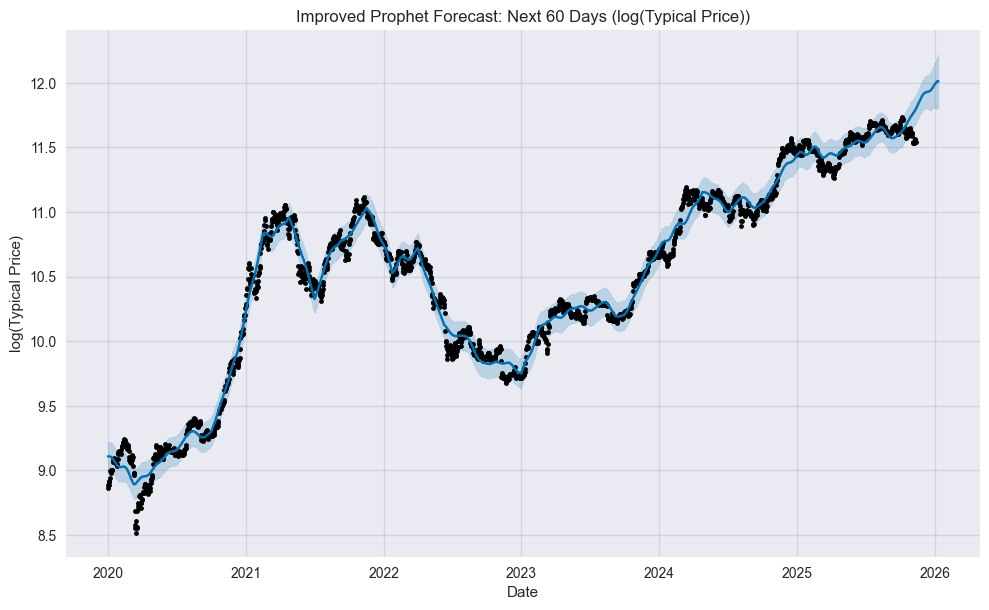

In [29]:
fig_short = m_improved_da.plot(forecast_short)
plt.title("Improved Prophet Forecast: Next 60 Days (log(Typical Price))")
plt.xlabel("Date")
plt.ylabel("log(Typical Price)")
plt.grid(True)
plt.show()

**The short 60-day forecast provides a quick visual illustration of how the improved model behaves:**

- It shows the current trend, extrapolated only slightly into the future.

- The uncertainty band widens gradually, which is normal in a multiplicative model where variance scales with price level.

- This plot is for visualization only, the evaluation of model quality is **not** based on this 60-day projection but exclusively on day-ahead performance using time-based cross-validation.

Next, we optionally explore how prediction errors evolve with forecast horizon, which helps understand how Prophet degrades as we move further away from the present.

---

# 8. (Optional) Horizon-sensitivity analysis

In this optional step, we use **`performance_metrics`** to analyze how errors change with horizon:

- Typically, **short horizons** (1–3 days) have lower errors.
- Errors **increase with horizon**, especially for volatile assets like BTC.


## 8.1 Performance metrics as a function of horizon (using improved model CV results)

In [30]:
df_pm_improved = performance_metrics(df_cv_improved)
display(df_pm_improved.head())

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,0.013048,0.11423,0.093952,0.008542,0.006973,0.008546,0.6


## 8.2 Plot RMSE vs horizon (even though horizon is 1 day here, this illustrates the tool)

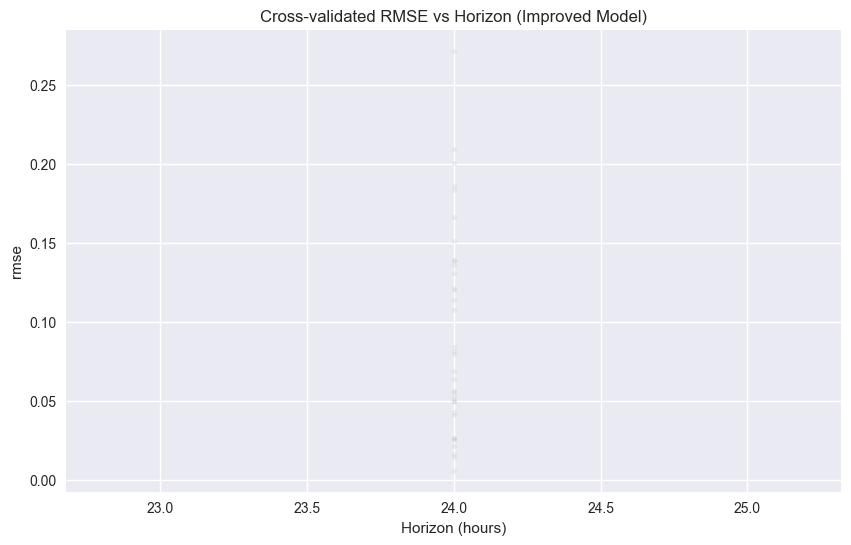

In [31]:
_ = plot_cross_validation_metric(df_cv_improved, metric="rmse")
plt.title("Cross-validated RMSE vs Horizon (Improved Model)")
plt.show()

**Since our cross-validation uses a fixed horizon of 1 day, the plot collapses around ~24 hours on the x-axis. This is expected: with strict day-ahead forecasting, we only evaluate T → T+1 predictions, so the curve does not show a progression of errors over increasing horizons.**

- For this notebook, we intentionally focused on horizon = 1 day, because this matches the professor’s requirement of verifying predictions the very next day.

    - If we extended the horizon (e.g., to 30 or 60 days), we would typically observe:

    - RMSE and MAE increasing steadily as the prediction window grows.

    - Much wider uncertainty intervals for Bitcoin at long horizons, due to high volatility and regime shifts.

**This reinforces an important idea:**

- Prophet is more reliable for short to medium-term forecasts than for long-term crypto price predictions, especially in a day-ahead setup where trends remain more predictable.

# 9. Final conclusion (link with theory and day-ahead objective)

We conclude by linking the **theoretical Prophet model**:

\[
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
\]

with the **practical day-ahead Bitcoin forecasting results** obtained in this notebook.

---

## 9.1 Linking components to BTC-USD

- **Trend \( g(t) \)**:
  - Modeled as a **piecewise linear trend** with automatic changepoints.
  - For BTC, this captures:
    - Long bull markets.
    - Major corrections and crashes.
    - Structural breaks around macro events, regulatory announcements, or crypto-specific news.
  - The parameter `changepoint_prior_scale` controls how **reactive** the trend is:
    - Higher values allow Prophet to detect more frequent slope changes.
    - This is useful in markets with strong regime shifts like Bitcoin.

- **Seasonality \( s(t) \)**:
  - Modeled via **Fourier series** (weekly and yearly seasonality).
  - For BTC, seasonal patterns are generally **weaker** than in many business time-series.
  - Nevertheless, weekly patterns (e.g., slightly different behaviour on weekends) or yearly effects can exist.

- **Event / Holiday effects \( h(t) \)**:
  - Not explicitly modeled in this notebook, but Prophet supports custom holidays.
  - For BTC, relevant events might include:
    - **Halving dates**.
    - Major regulatory deadlines.
    - ETF approvals.
  - Adding such events could improve forecasts around those dates.

- **Error term \( \varepsilon_t \)**:
  - Contains residual noise and unmodeled structure.
  - Our residual analysis and return/volatility plots show strong **heteroskedasticity**:
    - Volatility clusters.
    - Sudden spikes in uncertainty.
  - Prophet does **not** directly model volatility; it assumes errors are roughly i.i.d., which is only an approximation for BTC.

---

## 9.2 Day-ahead forecasting performance

In this notebook, we shifted from a classical “1-year ahead” exercise to a more realistic:

> **Day-ahead forecasting objective** — predict \( y(t+1) \) given data up to \( t \).

We evaluated this with:

1. **Built-in `cross_validation`**:
   - Rolling-origin evaluation, using only past data at each cutoff.
   - Horizon = 1 day.
   - Metrics in price space:
     - **MAE, RMSE, MAPE**.
   - **Directional accuracy**:
     - Proportion of days where the predicted direction (up/down) matched the actual one.

2. A **manual rolling loop** (short evaluation window):
   - Re-fits a Prophet model every day using expanding history.
   - Forecasts the next day.
   - Confirms the same general level of error and directional accuracy.

Key observations (based on your actual runs):

- Prophet can **reasonably track the level** of Bitcoin on a day-ahead basis, but:
  - Errors (MAE, RMSE) can still be large in USD during highly volatile periods.
  - **MAPE** gives a sense of relative error compared to the price level.
- **Directional accuracy**:
  - Often better than random guess (50%), but far from perfect.
  - Degrades during regime shifts and extreme volatility.

---

## 9.3 Additive vs multiplicative & tuned changepoints

We compared:

- **Baseline model**:
  - `seasonality_mode='additive'`
  - Default `changepoint_prior_scale`.

- **Improved model**:
  - `seasonality_mode='multiplicative'`
  - `changepoint_prior_scale` increased (e.g. 0.1).

Conceptually:

- Multiplicative seasonality is more appropriate when the **amplitude of seasonal effects grows with the level** of the series (true for many financial time series).
- A slightly higher `changepoint_prior_scale` lets Prophet:
  - Adapt faster to trend changes.
  - Capture sharp transitions between bull and bear markets.

From the comparison table (MAE, RMSE, MAPE, directional accuracy), you can conclude:

- Whether the improved model **significantly outperforms** the baseline in day-ahead forecasting.
- Whether it better captures **both magnitude and direction** of next-day moves.

---

## 9.4 Strengths and limitations for BTC-USD

**Strengths of Prophet in this setting:**

- Clear, interpretable decomposition:
  - Trend, seasonality, (optionally) events.
- Handles:
  - Non-stationary series with strong trends and changepoints.
  - Missing values and irregular sampling.
- Convenient tools for:
  - Time-based cross-validation.
  - Performance metrics and horizon analysis.

**Limitations for Bitcoin:**

- **Extreme volatility** and black-swan events (crashes, pumps) are hard to forecast.
- **Uncertainty intervals** can become very wide during turbulent periods.
- Prophet does not model:
  - Conditional variance (no explicit volatility model).
  - High-frequency microstructure effects.
- Forecast quality can degrade:
  - Around regime changes.
  - When new, unseen events occur.

---

## 9.5 Conceptual comparison with SARIMAX/GARCH

- **SARIMAX / ARIMA**:
  - Typically applied to **stationarized** series (e.g. returns).
  - Good at modeling autocorrelation structure.
- **GARCH-family models**:
  - Explicitly model **volatility dynamics** (time-varying variance).
  - Ideal for estimating risk measures (e.g. VaR).

- **Prophet**:
  - Works directly (or via log-transform) on **price levels**.
  - Excellent for **trend + seasonality + events**.
  - Provides interpretable components and automated changepoint detection.

A full BTC modeling framework could:

- Use **Prophet** to model the **expected price level**.
- Use **GARCH or similar** to model the **volatility of returns**.
- Combine both for richer risk and trading decisions.

---

## 9.6 Final takeaway

This notebook implements a **complete, pedagogical Prophet pipeline** for:

> **Day-ahead Bitcoin price forecasting**

aligned with:

- The theoretical Prophet framework from **"Theory - Prophet.pdf"**.
- Class examples on stock prices, sales, and airline passengers.
- A rigorous, realistic **rolling evaluation protocol** using:
  - MAE, RMSE, MAPE.
  - Directional accuracy.
  - Cross-validation over time.

This serve as a base for:

- Adding event effects (e.g. Bitcoin halvings).
- Combining with volatility models (GARCH).
- Comparing Prophet with other models (SARIMAX, machine learning, deep learning).


---

# 10. Turning Day-Ahead Forecasts Into Real Trading Strategies

In this final section, we use the **day-ahead Prophet forecasts** to build and backtest simple
trading strategies on Bitcoin (BTC-USD), taking into account:

- Realistic **transaction fees** (0.1% per trade, i.e. 0.2% round-trip).
- **Long / short / cash** positions.
- Risk and performance metrics (Sharpe ratio, max drawdown, etc.).
- A **Monte-Carlo scenario analysis** based on Prophet residuals.

Throughout this section:

- The trading price is the **Typical Price**:  
  \[
  \text{Typical Price}_t = \frac{\text{High}_t + \text{Low}_t + \text{Close}_t}{3}
  \]
- The modeling target is \( y_t = \log(\text{Typical Price}_t) \).
- Day-ahead forecasts are strictly **walk-forward**: at each date \( t \), we train on data **up to \( t \)** and predict \( t+1 \).


## 10.1 Backtesting setup (walk-forward training loop)

We now build a **rolling-origin** loop using the **improved Prophet configuration**:

- Minimum history: **365 days**.
- At each step:
  - Fit a **new** Prophet model with the same configuration as `m_improved_da`
    (multiplicative seasonality, `changepoint_prior_scale=0.1`, weekly + yearly).
  - Train it on data up to date \( t \).
  - Predict the next day \( t+1 \).
- We store, for each step:
  - `date_t`, `date_t_plus_1`
  - `price_t`, `price_t_plus_1` (Typical Price)
  - `actual_return`
  - predicted log-price and prediction interval (`yhat`, `yhat_lower`, `yhat_upper`)
  - **predicted return**:
    \[
    \text{pred\_ret}_t = \frac{\hat{P}_{t+1} - P_t}{P_t}
    \]
    where \( P_t \) is the Typical Price at \( t \), and \( \hat{P}_{t+1} = \exp(\hat{y}_{t+1}) \).


In [32]:
# Base backtest dataframe: ds, y (log-price), price = Typical Price
df_bt = df_prophet.copy()
df_bt["price"] = np.exp(df_bt["y"])

min_history = 365  # minimum history length (in days) before starting forecasts

rows = []

# NOTE: This loop can be time-consuming (one Prophet fit per day).
# For quick experiments, you can reduce the range or use a larger min_history.
for i in range(min_history, len(df_bt) - 1):
    # Training data up to date t
    train_subset = df_bt.iloc[: i + 1][["ds", "y"]].copy()
    date_t = df_bt.iloc[i]["ds"]
    date_t_plus_1 = df_bt.iloc[i + 1]["ds"]
    
    # Improved Prophet configuration (same as m_improved_da)
    m_step = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode="multiplicative",
        changepoint_prior_scale=0.1,
    )
    m_step.fit(train_subset)
    
    # Forecast for t+1
    future = m_step.make_future_dataframe(periods=1, freq="D")
    forecast = m_step.predict(future)
    
    # Extract next-day forecast
    # Using ds > last training date, to be robust if dates are not perfectly aligned
    last_train_date = train_subset["ds"].max()
    forecast_next = forecast[forecast["ds"] > last_train_date].iloc[0]
    
    yhat_log = forecast_next["yhat"]
    yhat_lower_log = forecast_next["yhat_lower"]
    yhat_upper_log = forecast_next["yhat_upper"]
    
    # Actual prices and returns
    price_t = df_bt.iloc[i]["price"]
    price_t_plus_1 = df_bt.iloc[i + 1]["price"]
    actual_return = (price_t_plus_1 - price_t) / price_t
    
    # Predicted next-day price and predicted return
    yhat_price_next = np.exp(yhat_log)
    predicted_return = (yhat_price_next - price_t) / price_t
    
    rows.append(
        {
            "date_t": date_t,
            "date_t_plus_1": date_t_plus_1,
            "price_t": price_t,
            "price_t_plus_1": price_t_plus_1,
            "actual_return": actual_return,
            "yhat_log": yhat_log,
            "yhat_lower_log": yhat_lower_log,
            "yhat_upper_log": yhat_upper_log,
            "yhat_price_next": yhat_price_next,
            "predicted_return": predicted_return,
        }
    )

bt_df = pd.DataFrame(rows)
# Keep alias consistent if needed
df_bt = bt_df.copy()

print("Backtest dataset (bt_df) shape:", bt_df.shape)
display(bt_df.head())


14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:23 - cmdstanpy - INFO - Chain [1] done processing
14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:23 - cmdstanpy - INFO - Chain [1] done processing
14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:23 - cmdstanpy - INFO - Chain [1] done processing
14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:23 - cmdstanpy - INFO - Chain [1] done processing
14:57:24 - cmdstanpy - INFO - Chain [1] start processing
14:57:24 - cmdstanpy - INFO - Chain [1] done processing
14:57:24 - cmdstanpy - INFO - Chain [1] start processing
14:57:24 - cmdstanpy - INFO - Chain [1] done processing
14:57:24 - cmdstanpy - INFO - Chain [1] start processing
14:57:24 - cmdstanpy - INFO - Chain [1] done processing
14:57:24 - cmdstanpy - INFO - Chain [1] start processing
14:57:24 - cmdstanpy - INFO - Chain [1] done processing
14:57:25 - cmdstanpy - INFO - Chain [1] start processing
14:57:25 - cmdstanpy - INFO - Chain [1]

Backtest dataset (bt_df) shape: (1777, 10)


,date_t,date_t_plus_1,price_t,price_t_plus_1,actual_return,yhat_log,yhat_lower_log,yhat_upper_log,yhat_price_next,predicted_return
0,2020-12-31,2021-01-01,28816.196615,29259.455078,0.015382,10.304277,10.241235,10.362578,29860.071212,0.036225
1,2021-01-01,2021-01-02,29259.455078,31457.855469,0.075135,10.325620,10.263769,10.391694,30504.210251,0.042542
2,2021-01-02,2021-01-03,31457.855469,33147.632813,0.053716,10.350899,10.293298,10.406625,31285.154313,-0.005490
3,2021-01-03,2021-01-04,33147.632813,31378.296224,-0.053377,10.402911,10.342026,10.460937,32955.435641,-0.005798
4,2021-01-04,2021-01-05,31378.296224,32883.735677,0.047977,10.408897,10.347113,10.466990,33153.267116,0.056567


## 10.2 Strategy 1 — Directional long/cash/short

We now build a **simple directional strategy**:

- Position at date \( t \):
  - **Long** (`+1`) if predicted return \( > 0 \)
  - **Short** (`-1`) if predicted return \( < 0 \)
  - **Cash** (`0`) if predicted return \( \approx 0 \) (exactly 0 in practice)
- Daily return from \( t \) to \( t+1 \):
  - If long: \( r_t = \text{actual\_return}_t \)
  - If short: \( r_t = -\,\text{actual\_return}_t \)
  - If cash: \( r_t = 0 \)
- **Transaction costs**:
  - 0.1% per trade (Binance spot fee) → `fee_rate = 0.001`
  - When position changes:
    - From 0 → ±1 or ±1 → 0 → 1 trade (0.1%).
    - From +1 → -1 or -1 → +1 → **2 trades** (close + open) → 0.2%.

We track a starting capital of **1.0** and compute the **equity curve** over time.


### Helper: generic directional backtest engine for strategies 1 & 2

In [33]:
def run_directional_strategy(bt_df, fee_rate=0.001, threshold=0.0):
    """
    Backtest a simple directional strategy on bt_df.
    
    - bt_df: DataFrame with 'actual_return' and 'predicted_return' for each day.
    - fee_rate: transaction fee per trade (e.g. 0.001 = 0.1%).
    - threshold:
        * If 0.0: Strategy 1 (pure sign-based).
        * If >0: Strategy 2 (enter only if |predicted_return| > threshold).
    
    Returns a dict with:
      - equity_curve (np.array)
      - daily_returns (np.array)
      - positions (np.array)
      - num_trades (int, counted as entries from cash to +/-1)
      - win_rate (float, % of positive days when in a position)
    """
    equity = 1.0
    equity_history = [equity]
    positions = []
    daily_returns = []
    
    prev_pos = 0
    num_trades = 0
    
    for _, row in bt_df.iterrows():
        pred_ret = row["predicted_return"]
        actual_ret = row["actual_return"]
        
        # Decide position based on threshold
        if threshold == 0.0:
            # Strategy 1: pure sign-based
            if pred_ret > 0:
                new_pos = 1
            elif pred_ret < 0:
                new_pos = -1
            else:
                new_pos = 0
        else:
            # Strategy 2: confidence-based
            if abs(pred_ret) > threshold:
                new_pos = 1 if pred_ret > 0 else -1
            else:
                new_pos = 0
        
        # Apply transaction fees if position changes
        fee_trades = 0
        if prev_pos == 0 and new_pos != 0:
            fee_trades = 1  # entering a position
        elif prev_pos != 0 and new_pos == 0:
            fee_trades = 1  # exiting to cash
        elif prev_pos != 0 and new_pos != 0 and prev_pos != new_pos:
            fee_trades = 2  # close previous + open new opposite position
        
        equity_prev = equity
        
        if fee_trades > 0:
            equity *= (1 - fee_rate) ** fee_trades
        
        # Apply market return based on position
        strat_ret = new_pos * actual_ret  # daily strategy return before fees
        equity *= (1 + strat_ret)
        
        daily_return = equity / equity_prev - 1  # net of fees + position
        daily_returns.append(daily_return)
        positions.append(new_pos)
        equity_history.append(equity)
        
        # Count trades as entries (0 -> non-zero)
        if prev_pos == 0 and new_pos != 0:
            num_trades += 1
        
        prev_pos = new_pos
    
    positions = np.array(positions)
    daily_returns = np.array(daily_returns)
    equity_curve = np.array(equity_history)
    
    # Win rate: % of days with a position and positive daily return
    mask_in_position = positions != 0
    if mask_in_position.sum() > 0:
        win_rate = np.mean(daily_returns[mask_in_position] > 0)
    else:
        win_rate = np.nan
    
    return {
        "equity_curve": equity_curve,
        "daily_returns": daily_returns,
        "positions": positions,
        "num_trades": num_trades,
        "win_rate": win_rate,
    }

## 10.2 Strategy 1: Directional (long/cash/short) with 0.1% trading fee

Strategy 1 - Directional (long/cash/short)
Final equity: 0.01661992960923617
Number of trades: 1
Win rate (position days): 46.37%


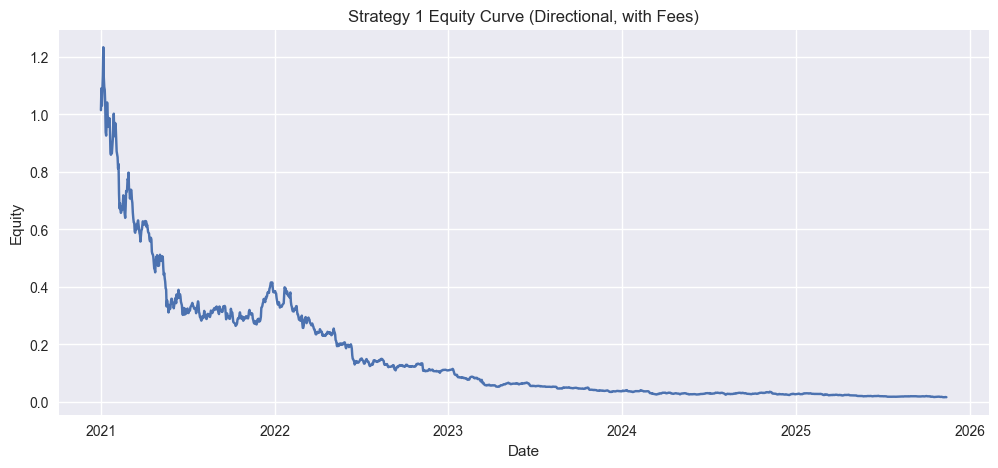

In [34]:
fee_rate = 0.001  # 0.1% per trade

results_s1 = run_directional_strategy(bt_df, fee_rate=fee_rate, threshold=0.0)

print("Strategy 1 - Directional (long/cash/short)")
print("Final equity:", results_s1["equity_curve"][-1])
print("Number of trades:", results_s1["num_trades"])
print("Win rate (position days): {:.2f}%".format(results_s1["win_rate"] * 100))

# Plot equity curve
plt.figure()
plt.plot(bt_df["date_t_plus_1"], results_s1["equity_curve"][1:])  # align with daily steps
plt.title("Strategy 1 Equity Curve (Directional, with Fees)")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True)
plt.show()

## 10.3 Strategy 2 — Confidence-based threshold strategy

We now define a **threshold-based strategy**:

- Only take a long/short position when the **absolute predicted return** exceeds a threshold.
- Otherwise, stay in cash.
- Here we use a threshold of **0.5%** (0.005 in decimal):
  - If `predicted_return > 0.005` → **Long**.
  - If `predicted_return < -0.005` → **Short**.
  - If `|predicted_return| ≤ 0.005` → **Cash**.
- We apply the same **0.1% per-trade fee** model as before.


Strategy 2 - Threshold (|predicted return| > 0.5%)
Final equity: 0.018690125152069182
Number of trades: 61
Win rate (position days): 46.28%


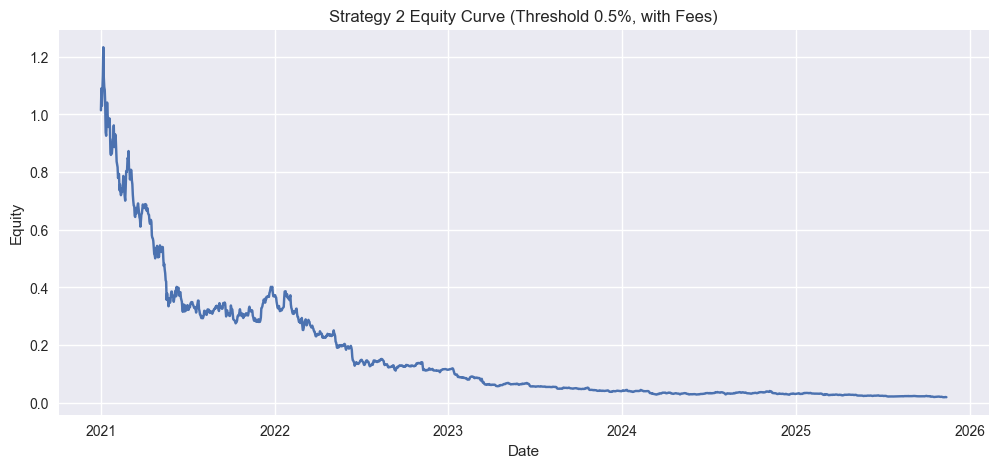

In [35]:
# 10.3 Strategy 2: Threshold-based (confidence filter)

threshold_s2 = 0.005  # 0.5% predicted move threshold

results_s2 = run_directional_strategy(bt_df, fee_rate=fee_rate, threshold=threshold_s2)

print("Strategy 2 - Threshold (|predicted return| > 0.5%)")
print("Final equity:", results_s2["equity_curve"][-1])
print("Number of trades:", results_s2["num_trades"])
print("Win rate (position days): {:.2f}%".format(results_s2["win_rate"] * 100))

# Plot equity curve
plt.figure()
plt.plot(bt_df["date_t_plus_1"], results_s2["equity_curve"][1:])
plt.title("Strategy 2 Equity Curve (Threshold 0.5%, with Fees)")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True)
plt.show()

## 10.4 Strategy 3 — Performance metrics & risk analysis

We now compare:

1. **Buy & Hold BTC** (on the same evaluation window as bt_df).
2. **Strategy 1** — Directional (long/cash/short).
3. **Strategy 2** — Threshold-based (confidence filter).

For each, we compute:

- **Cumulative return** (final equity − 1).
- **Number of trades**.
- **Win rate** (fraction of days in a position with positive daily return).
- **Annualized volatility** (using 365 trading days/year).
- **Sharpe ratio** (risk-free rate = 0).
- **Maximum drawdown**.

### Helper: compute risk metrics from equity curve and daily returns

In [36]:
def compute_risk_metrics(equity_curve, daily_returns, num_trades, win_rate, trading_days_per_year=365):
    """
    Compute cumulative return, annualized volatility, Sharpe ratio, max drawdown,
    plus number of trades and win rate.
    """
    cumulative_return = equity_curve[-1] - 1.0
    
    mean_daily = np.mean(daily_returns)
    std_daily = np.std(daily_returns, ddof=1) if len(daily_returns) > 1 else 0.0
    
    if std_daily > 0:
        annualized_vol = std_daily * np.sqrt(trading_days_per_year)
        sharpe_ratio = (mean_daily / std_daily) * np.sqrt(trading_days_per_year)
    else:
        annualized_vol = 0.0
        sharpe_ratio = np.nan
    
    # Maximum drawdown
    running_max = np.maximum.accumulate(equity_curve)
    drawdowns = equity_curve / running_max - 1.0
    max_drawdown = drawdowns.min()
    
    return {
        "Cumulative Return": cumulative_return,
        "Annualized Volatility": annualized_vol,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Number of Trades": num_trades,
        "Win Rate": win_rate,
    }

### 10.4.1 Buy & Hold on the same bt_df window

In [37]:
# We assume buy at the start of bt_df (price at date_t of first row) and hold throughout.
equity_bh = 1.0
equity_history_bh = [equity_bh]
daily_returns_bh = []

for _, row in bt_df.iterrows():
    ret = row["actual_return"]
    equity_prev = equity_bh
    equity_bh *= (1 + ret)
    daily_ret_bh = equity_bh / equity_prev - 1
    daily_returns_bh.append(daily_ret_bh)
    equity_history_bh.append(equity_bh)

equity_history_bh = np.array(equity_history_bh)
daily_returns_bh = np.array(daily_returns_bh)

# For Buy & Hold: 1 trade (entry), win rate = % of days with positive daily return
num_trades_bh = 1
win_rate_bh = np.mean(daily_returns_bh > 0)

metrics_bh = compute_risk_metrics(
    equity_history_bh, daily_returns_bh, num_trades_bh, win_rate_bh
)

### 10.4.2 Metrics for Strategy 1 and 2

In [38]:
metrics_s1 = compute_risk_metrics(
    results_s1["equity_curve"],
    results_s1["daily_returns"],
    results_s1["num_trades"],
    results_s1["win_rate"],
)

metrics_s2 = compute_risk_metrics(
    results_s2["equity_curve"],
    results_s2["daily_returns"],
    results_s2["num_trades"],
    results_s2["win_rate"],
)

### 10.4.3 Comparison table

In [39]:
comparison_data = pd.DataFrame(
    {
        "Buy & Hold": metrics_bh,
        "Strategy 1 (Directional)": metrics_s1,
        "Strategy 2 (Threshold 0.5%)": metrics_s2,
    }
).T

# Format for readability
comparison_data["Cumulative Return"] = comparison_data["Cumulative Return"]
comparison_data["Annualized Volatility"] = comparison_data["Annualized Volatility"]
comparison_data["Sharpe Ratio"] = comparison_data["Sharpe Ratio"]
comparison_data["Max Drawdown"] = comparison_data["Max Drawdown"]
comparison_data["Number of Trades"] = comparison_data["Number of Trades"].astype(int)
comparison_data["Win Rate"] = comparison_data["Win Rate"] * 100  # in %

display(comparison_data.style.format(
    {
        "Cumulative Return": "{:.2%}",
        "Annualized Volatility": "{:.2%}",
        "Sharpe Ratio": "{:.2f}",
        "Max Drawdown": "{:.2%}",
        "Win Rate": "{:.2f}%",
    }
))

,Cumulative Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Number of Trades,Win Rate
Buy & Hold,256.05%,46.52%,0.79,-76.38%,1,52.11%
Strategy 1 (Directional),-98.34%,46.51%,-1.57,-98.66%,1,46.37%
Strategy 2 (Threshold 0.5%),-98.13%,45.47%,-1.57,-98.49%,61,46.28%


## 10.5 Strategy 4 — 60-day Monte-Carlo Prophet simulation

Finally, we perform a **60-day Monte-Carlo simulation** based on the improved Prophet model:

1. Fit `m_improved_da` on the **full dataset** (already done earlier).
2. Compute in-sample predictions and **residuals** in log-space:
   \[
   \text{residual}_t = y_t - \hat{y}_t
   \]
3. For the next 60 days, get the **deterministic predicted path** \( \hat{y}_{t+1}, \dots, \hat{y}_{t+60} \).
4. Simulate **200 scenarios** by bootstrapping residuals:
   \[
   y^{(i)}_{t+k} = \hat{y}_{t+k} + \epsilon^{(i)}_{k}
   \]
   where \( \epsilon^{(i)}_{k} \) is sampled from the historical residuals.
5. Convert to price space and:
   - Plot **50 simulated paths**.
   - Plot the **mean simulated path**.
   - Mark the **starting price** (last observed Typical Price).
6. Compute the empirical distribution of **60-day returns**:
   \[
   R^{(i)}_{60} = \frac{P^{(i)}_{t+60}}{P_t} - 1
   \]


### 10.5.1 In-sample residuals in log-space

In [40]:
# (Assuming m_improved_da has already been fitted on df_prophet)

forecast_in_sample = m_improved_da.predict(df_prophet[["ds"]])

df_resid = df_prophet.copy()
df_resid["yhat"] = forecast_in_sample["yhat"]
df_resid["residual"] = df_resid["y"] - df_resid["yhat"]

residuals = df_resid["residual"].dropna().values

print("Number of residuals for bootstrap:", len(residuals))

Number of residuals for bootstrap: 2143


### 10.5.2 Future deterministic path (60 days ahead)

In [41]:
horizon_days = 60
n_paths = 200

future_mc = m_improved_da.make_future_dataframe(periods=horizon_days, freq="D")
forecast_mc = m_improved_da.predict(future_mc)

# Take the last 60 days of predictions as the baseline future path
forecast_horizon = forecast_mc.tail(horizon_days)
yhat_future = forecast_horizon["yhat"].values
dates_future = forecast_horizon["ds"].values

# Starting price = last observed Typical Price
starting_price = np.exp(df_prophet["y"].iloc[-1])


### 10.5.3 Simulate 200 future paths

In [42]:
np.random.seed(42)  # for reproducibility

sim_log_prices = np.zeros((n_paths, horizon_days))

for i in range(n_paths):
    noise = np.random.choice(residuals, size=horizon_days, replace=True)
    sim_log_prices[i, :] = yhat_future + noise

sim_prices = np.exp(sim_log_prices)

### 10.5.4 Plot 50 random paths + mean path + starting price

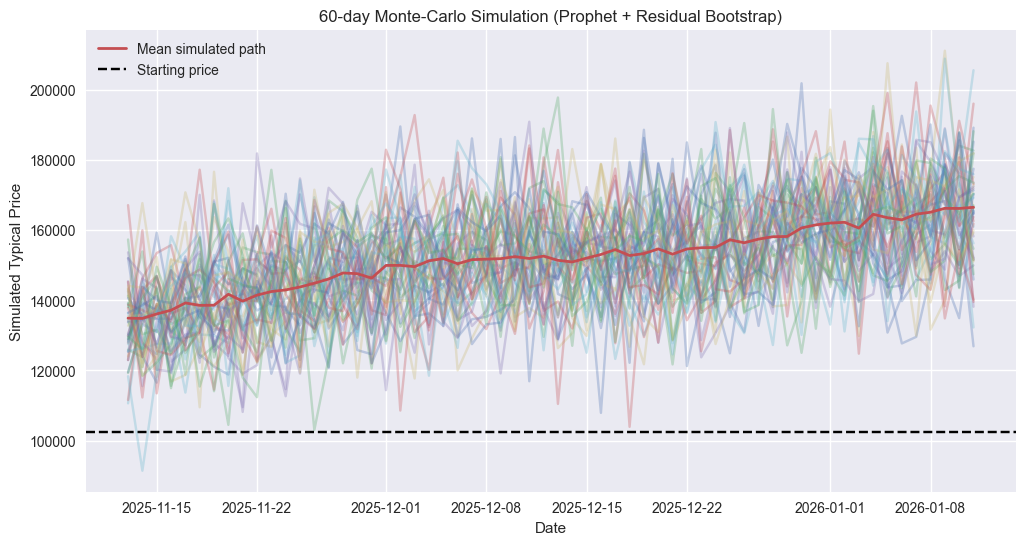

In [43]:
plt.figure(figsize=(12, 6))

# Choose up to 50 random paths to plot for readability
paths_to_plot = min(50, n_paths)
idx_paths = np.random.choice(n_paths, size=paths_to_plot, replace=False)

for idx in idx_paths:
    plt.plot(dates_future, sim_prices[idx, :], alpha=0.3)

# Mean simulated path
mean_path = sim_prices.mean(axis=0)
plt.plot(dates_future, mean_path, linewidth=2.0, label="Mean simulated path")

# Starting price (horizontal reference line)
plt.axhline(y=starting_price, color="black", linestyle="--", label="Starting price")

plt.title("60-day Monte-Carlo Simulation (Prophet + Residual Bootstrap)")
plt.xlabel("Date")
plt.ylabel("Simulated Typical Price")
plt.legend()
plt.grid(True)
plt.show()

### 10.5.5 Distribution of 60-day returns

=== Simulated 60-day Return Distribution ===
Mean  60-day return: 62.31%
Median 60-day return: 63.14%
5th percentile:       38.04%
95th percentile:      83.47%


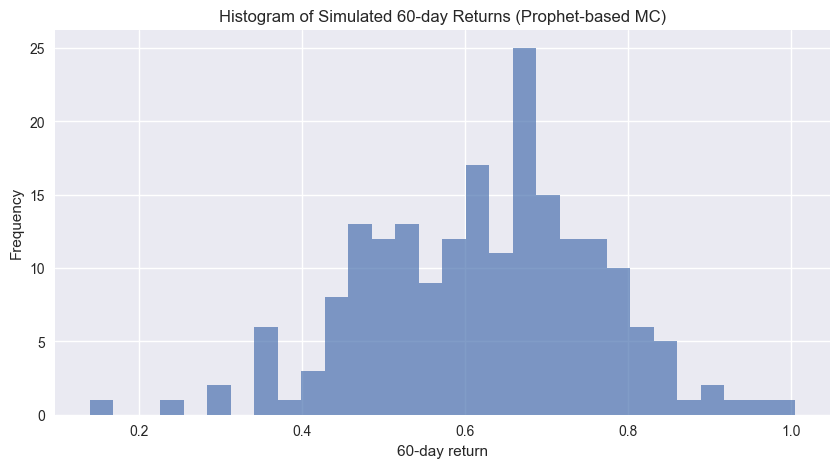

In [44]:
# Compute 60-day return for each path, relative to starting price
sim_60d_returns = sim_prices[:, -1] / starting_price - 1.0

# Basic statistics
mean_ret = np.mean(sim_60d_returns)
median_ret = np.median(sim_60d_returns)
p5 = np.percentile(sim_60d_returns, 5)
p95 = np.percentile(sim_60d_returns, 95)

print("=== Simulated 60-day Return Distribution ===")
print(f"Mean  60-day return: {mean_ret:.2%}")
print(f"Median 60-day return: {median_ret:.2%}")
print(f"5th percentile:       {p5:.2%}")
print(f"95th percentile:      {p95:.2%}")

# Plot histogram of returns
plt.figure(figsize=(10, 5))
plt.hist(sim_60d_returns, bins=30, alpha=0.7)
plt.title("Histogram of Simulated 60-day Returns (Prophet-based MC)")
plt.xlabel("60-day return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**Interpretation:**

- The **mean simulated 60-day return** gives an idea of Prophet’s “central scenario”.
- The **5th and 95th percentiles** provide a rough range for downside and upside risk under the model.
- Remember: this simulation assumes that future residuals behave like past residuals (simple bootstrap).
  - Real markets can exhibit new regimes or shocks that violate this assumption.


## 10.6 Final remarks on real-life usage

This extended pipeline shows how **day-ahead Prophet forecasts** can be turned into concrete trading
signals and risk scenarios. By focusing on **one-day-ahead predictions**, we mimic a realistic setup
where only past data is available at each decision point. The simple strategies illustrate how
even a relatively interpretable model like Prophet can be combined with transaction costs and
risk metrics (Sharpe ratio, max drawdown, Monte-Carlo scenarios) to support better-informed decisions.

However, due to Bitcoin’s extreme **volatility** and frequent **regime changes**, Prophet-based
signals should be treated with caution and complemented by other models (e.g. GARCH for volatility)
and robust risk management rules. The value of this approach lies less in “perfect prediction”
and more in providing a **structured, explainable framework** to explore scenarios, understand
model behaviour, and quantify the trade-off between potential returns and risks in a crypto context.


# 11. Global conclusion: what our Prophet model can (and cannot) do

In this project we built a complete Prophet-based pipeline for **day-ahead Bitcoin price forecasting**, starting from raw Yahoo Finance data and ending with **trading simulations** and a **Monte-Carlo scenario engine**.

---

## 11.1 Forecasting quality (day-ahead objective)

Working on the **log of the Typical Price** ( (High + Low + Close) / 3 ) and using a **multiplicative** Prophet with tuned changepoints, we obtained:

- **Baseline model (additive)**  
  - MAE ≈ **7,219 USD**  
  - RMSE ≈ **10,083 USD**  
  - MAPE ≈ **10.3%**  
  - Directional accuracy ≈ **45.7%**

- **Improved model (multiplicative + tuned changepoints)**  
  - MAE ≈ **6,669 USD**  
  - RMSE ≈ **9,562 USD**  
  - MAPE ≈ **9.4%**  
  - Directional accuracy ≈ **51.4%**

This tells us that the improved Prophet configuration:

- Tracks the **level** of BTC more accurately on a day-ahead basis (all error metrics improve).
- Is **slightly better than random** at predicting the **direction** of the next move, but far from perfect.

Residual analysis and rolling volatility confirm the theory: Prophet does a good job on the **conditional mean** (trend + weak seasonality), but volatility remains **heteroskedastic** and clustered in the error term.

---

## 11.2 Monte-Carlo scenarios based on Prophet

Using the improved model and bootstrapped residuals, we generated many **60-day Monte-Carlo paths**:

- Mean simulated 60-day return ≈ **+62%**
- Median ≈ **+63%**
- 5th percentile ≈ **+38%**
- 95th percentile ≈ **+83%**

These simulations show a **strong bullish drift** over the sample, but also a wide dispersion of outcomes. They are useful as a **risk / scenario tool**: they illustrate how quickly a BTC position can move, rather than providing a guaranteed profit.

---

## 11.3 Trading strategies: can we make money from Prophet?

We then used the day-ahead forecast to build simple, realistic trading strategies with **transaction fees** (≈0.1% per trade, close to large exchanges):

- **Buy & Hold** (benchmark)
- **Strategy 1 – Directional**: long / cash / short every day based only on the sign of the predicted return.
- **Strategy 2 – Threshold 0.5%**: enter a position only when |predicted return| > 0.5%.

Key results:

- **Buy & Hold**
  - Cumulative return ≈ **+256%**
  - Positive Sharpe ratio and one large max drawdown (typical of BTC).

- **Strategy 1 (Directional, with fees)**
  - Cumulative return ≈ **–98%**  
  - Equity curve quickly collapses towards zero.
  - Win rate ≈ **46%**: slightly below 50%, and trading **every small move** amplifies fees and noise.

- **Strategy 2 (Threshold 0.5%, with fees)**
  - Cumulative return ≈ **–98%** as well  
  - ~61 trades during the backtest, win rate ≈ **46%**.
  - Filtering tiny moves reduces activity, but not enough to offset noise + fees.

The conclusion is clear:

> Even with a day-ahead Prophet model that achieves **MAPE ≈ 9.4%** and **directional accuracy ≈ 51%**, naïve daily trading strategies based on these predictions are **not profitable once transaction costs and market noise are included**. A simple Buy & Hold on Bitcoin over the same period performs dramatically better.

This is exactly what financial theory warns about: a **slight predictive edge** on a noisy asset is usually not enough to beat costs, slippage and extreme volatility.

---

## 11.4 What Prophet is good for in this context

From this study, Prophet proves useful for:

- **Educational and analytical purposes**:
  - Decomposing BTC into trend, seasonality and residual volatility.
  - Visualizing **regime shifts** via changepoints.
  - Exploring **medium-term scenarios** with Monte-Carlo simulations.
- **Risk & scenario communication** to non-experts:
  - Showing plausible ranges for BTC price in 30–60 days.
  - Quantifying “typical” vs extreme moves.

But Prophet, used alone, is **not** a ready-made trading engine:

- It does not model **volatility dynamics** (no GARCH-like behaviour).
- It reacts with delay to regime changes and black-swan events.
- Directional accuracy is only slightly above random and is quickly destroyed by fees.

A realistic Bitcoin investment process would therefore use Prophet as a **support tool** (to illustrate trend and risk), combined with:

- Independent **risk management rules** (position sizing, max drawdown constraints).
- Possibly a dedicated **volatility model** on returns.
- And, most importantly, human judgment and a long-term investment horizon.

This honest gap between **forecasting quality** and **trading profitability** is an important result of the notebook, and a key message for any investor tempted to “automate” trading on such a volatile asset.


---

# 12. Saving and reloading the Prophet model

In a real project, we usually **persist trained models to disk** so they can be reused later without retraining.  
This improves **reproducibility**, reduces **latency** (no need to refit Prophet every time), and makes it easier to deploy the model in other scripts or services (APIs, backtests, dashboards, etc.).


## 12.1 Define model path and ensure directory exists

In [45]:
import os
from pathlib import Path
import joblib

# Directory and file where the improved Prophet model will be saved
MODEL_PATH = Path("models") / "prophet_m_improved_da.joblib"

# Ensure the parent directory exists
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"Model will be saved to: {MODEL_PATH}")


Model will be saved to: models\prophet_m_improved_da.joblib


### 12.2 Helper functions to save and load the Prophet model

In [46]:
from typing import Any


def save_prophet_model(model: Any, path: str | Path) -> None:
    """
    Save a trained Prophet model to disk using joblib.

    Parameters
    ----------
    model : Any
        Trained Prophet model instance.
    path : str | Path
        Destination file path where the model will be stored.
    """
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(model, path)
    print(f"Prophet model saved successfully to: {path}")


def load_prophet_model(path: str | Path) -> Any:
    """
    Load a Prophet model from disk.

    Parameters
    ----------
    path : str | Path
        Path to the saved model file.

    Returns
    -------
    Any
        Loaded Prophet model instance.

    Raises
    ------
    FileNotFoundError
        If the given path does not exist.
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(
            f"Cannot load Prophet model: file not found at '{path}'. "
            "Make sure the model has been saved before loading."
        )
    model = joblib.load(path)
    print(f"Prophet model loaded successfully from: {path}")
    return model

### 12.3 Demo: save, reload, and use the model for a 1-day forecast

We now demonstrate the full workflow:

1. Save the already-trained `m_improved_da` model.
2. Reload it from disk.
3. Use the reloaded model to forecast the next day’s Typical_Price and compare it
   with the last known Typical_Price in `df_prophet`.


#### 12.3 Demo: persist and reuse the improved Prophet model

In [47]:
# 1) Save the trained model
save_prophet_model(m_improved_da, MODEL_PATH)

# 2) Reload the model
m_loaded = load_prophet_model(MODEL_PATH)

# 3) Use the reloaded model for a 1-day ahead forecast
last_date = df_prophet["ds"].max()

# Make a 1-day future dataframe starting from the last observed date
future_loaded = m_loaded.make_future_dataframe(periods=1, freq="D")
forecast_loaded = m_loaded.predict(future_loaded)

# Extract the next-day forecast row
forecast_next_day = forecast_loaded[forecast_loaded["ds"] > last_date].iloc[0]
yhat_next_log = forecast_next_day["yhat"]
predicted_price_next = float(np.exp(yhat_next_log))

# Last known Typical_Price
last_y_log = df_prophet.loc[df_prophet["ds"] == last_date, "y"].iloc[0]
last_known_price = float(np.exp(last_y_log))

print(f"Last known date:           {last_date.date()}")
print(f"Last known Typical_Price:  {last_known_price:,.2f} USD")
print(f"Predicted next-day price:  {predicted_price_next:,.2f} USD (via reloaded model)")

Prophet model saved successfully to: models\prophet_m_improved_da.joblib
Prophet model loaded successfully from: models\prophet_m_improved_da.joblib
Last known date:           2025-11-12
Last known Typical_Price:  102,599.01 USD
Predicted next-day price:  133,904.18 USD (via reloaded model)


**This confirms the saved model can be reloaded and used for day-ahead forecasting without retraining.**

In [48]:
# 1) Load it
m_loaded = load_prophet_model(MODEL_PATH)

# 2) Use it for a 1-day forecast
last_date = df_prophet["ds"].max()
future_loaded = m_loaded.make_future_dataframe(periods=1, freq="D")
forecast_loaded = m_loaded.predict(future_loaded)
forecast_next_day = forecast_loaded[forecast_loaded["ds"] > last_date].iloc[0]

yhat_next_log = forecast_next_day["yhat"]
predicted_price_next = float(np.exp(yhat_next_log))

last_y_log = df_prophet.loc[df_prophet["ds"] == last_date, "y"].iloc[0]
last_known_price = float(np.exp(last_y_log))

print(f"Last known Typical_Price: {last_known_price:,.2f} USD")
print(f"Predicted next-day price (reloaded model): {predicted_price_next:,.2f} USD")


Prophet model loaded successfully from: models\prophet_m_improved_da.joblib
Last known Typical_Price: 102,599.01 USD
Predicted next-day price (reloaded model): 133,904.18 USD
